# 2D PUZZLE GRID
# Designing program 
## Non linear Joints Bachelor project 2019-2020
### Maxime Fellrath, 274858

In [1]:
import random
import igl
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import math
import tripy
import copy
import ipywidgets as widgets
import shapely.geometry as shy
from shapely.geometry import Point
from numpy import linalg as LA
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
from random import randrange, uniform
from scipy.spatial import Delaunay
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.pyplot import figure
colors = np.array(['#FFF8DC', '#FFEBCD','#FFE4C4','#FFDEAD','#F5DEB3','#DEB887','#D2B48C','#BC8F8F','#F4A460','#DAA520','#B8860B','#CD853F','#D2691E','#8B4513','#A52A2A','#800000'])

epsilon=1e-5


# Global variables

In [2]:
gridSize = 1000


# display

In [251]:
def simpleDisplay(figure):
    patches = []
    xmax=30
    ymax=30
    xmin =-30
    ymin=-30
    k=0
    fig2 = plt.figure(num=None, figsize=(8, 8))
    ax2 = fig2.gca()
    for i in range(len(figure)):
        polygon = Polygon(figure[i], fill=True, facecolor=colors[i],edgecolor='black',label='figure'+str(i))
        ax2.add_artist(polygon)

        ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    plt.show()
    
def printArray(piece):
    print("np.array([")
    for i in range(len(piece)):
        print("np.array([")
        for j in range(len(piece[i])):
            if(j!=len(piece[i])-1):
                print("[", piece[i][j][0], ",", piece[i][j][1],"],")
            else:
                print("[", piece[i][j][0], ",", piece[i][j][1],"]")
        print("]),")
    print("])")


# normals

In [4]:
def cross(a,b):
    return a[0]*b[1]-b[0]*a[1]

def is_between(a, b, c): # is point c between point a and b
    if(np.allclose(a,c) or np.allclose(b,c)):
        return False
    cross_product= cross((c-a),(b-a))
    if abs(cross_product) > epsilon:
        return False
    dotproduct = (b-a)@(c-a)
    if dotproduct < 0:
        return False
    squaredlengthba = np.sum(np.square(b-a))
    if dotproduct > squaredlengthba:
        return False
    return True

def isTouching(v1,v2, u1,u2):
    if((np.allclose(v1,u1) and np.allclose(v2,u2)) or  (np.allclose(v2,u1) and np.allclose(v1,u2))):
        return True
    return abs(cross(v1-v2, u1-u2)) < epsilon and (is_between(v1,v2,u1) or is_between(v1,v2,u2) or is_between(u1,u2,v1) or is_between(u1,u2,v2))  
def compute_normal_edge(v1,v2,i,j):
    normal = np.array(v2-v1)
    normal[0], normal[1] = normal[1], -normal[0]
    normal = normal / LA.norm(normal)
    return np.around(np.array(normal), decimals = 1)

def compute_normals_shape(shape):
    normals_of_shape= np.array([compute_normal_edge(shape[i],shape[(i+1)%len(shape)]) for i in range(len(shape))])
    return normals_of_shape

def compute_normals_2_shapes(shape1, shape2): 
    result = np.array([compute_normal_edge(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)]) for i in range (len(shape1)) for j in range (len(shape2)) if(isTouching(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)]))])   
    return set(tuple(i) for i in result)

def compute_normals_dict(figure):
    normals_dic = {}
    for i in range(len(figure)):
        for j in range(len(figure)):
            if(i != j):
                normals_dic[i,j]= compute_normals_2_shapes(figure[i], figure[j])
    return normals_dic

def computeDirections(piece, randomness = False ): 
    normalsDictionnary = compute_normals_dict(piece)
    directions = []
    r,s=1,1
    if(randomness):
        r,s = np.random.uniform(0.7, 1.3), np.random.uniform(0.7,1.3)
    for i in range(len(piece)):
        directionsi = []

        for key in normalsDictionnary:
            if(key[0]==i and len(normalsDictionnary[key]) > 0) :
                directionsi.append(np.array((list(normalsDictionnary[key])[0])))
        directions.append(directionsi)

    for i in range(len(directions)):
        directions[i] = (r *directions[i][0]+ s * directions[i][1])/ np.linalg.norm(r *directions[i][0]+ s * directions[i][1])
    return directions

# graph

In [5]:
baseGridArr =700* np.array([([(i,j),(i+1, j),(i+1,j+1),(i,j+1)]) for i in range(4) for j in range(4)])

def isNeighboorsOf(shape1, shape2):
    #simpleDisplay(np.array([shape1,shape2]))
    for i in range(len(shape1)):
        for j in range(len(shape2)):
            if(isTouching(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)])):
                return True
    return False
def isNeighboorsVertical(shape1, shape2):
    #simpleDisplay(np.array([shape1,shape2]))
    for i in range(len(shape1)):
        for j in range(len(shape2)):
            if(isTouching(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)])):
                if(shape1[i][0]==shape1[(i+1)%len(shape1)][0]):
                    return True
    return False
def generateGridGraph(grid):
    G = nx.Graph()
    for i in range(len(grid)):
        G.add_node(i)
    for i in range(len(grid)):
        for j in range(len(grid)):
            if(i!=j and isNeighboorsOf(grid[i],grid[j])):
                G.add_edge(i,j)
                G.add_edge(j,i)
   

    return G
graph = generateGridGraph(baseGridArr)


# cycle functions

In [6]:
def getCycles(graph, grid):
    cycles = nx.minimum_cycle_basis(graph)
    finalCycles = [cycles[0]]
    append = True
    for i in range(len(cycles)): 
        append = True
        for j in range(len(finalCycles)):
            if (intersection(cycles[i], finalCycles[j])!= []):
                append=False        
        if(append and cycles[i] not in finalCycles ):
            finalCycles.append(cycles[i])
    finalCycles= [ rearangeCycle(finalCycles[i], grid)  for i in range(len(finalCycles)) ]
    return finalCycles   

def rearangeCycle(cycle, grid):
    temp = [cycle[0]]
    for i in range(len(cycle)):
        for j in range(len(cycle)):
            if(isNeighboorsOf(grid[temp[i]], grid[cycle[j]])):
                if(cycle[j] not in temp):
                    temp.append(cycle[j])
                    break
    return temp
    
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
def intersection2DArray(a1, a2):
    temp = []
    for i in range(len(a1)):
        for j in range(len(a2)):
            
            if (np.allclose(a1[i],a2[j])):
                temp.append(a1[i])
    return np.array(temp)
def correctPoints(v1):
    v1 = np.round(np.flip(v1, 0),decimals=3)
    _, idx = np.unique(v1,axis = 0, return_index=True)
    return v1[np.sort(idx)]

# 2 parts joint design

In [7]:
def designJoint2parts(p1,p2,v, width, height, distance_to_center=0.5 ):
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    v = v/ np.linalg.norm(v)
    nrows, ncols = p1.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [p1.dtype]}
    commonPoint = intersection2DArray(p1,p2)
    
    JointAxis = np.asarray((commonPoint[1]-commonPoint[0])/np.linalg.norm(commonPoint[1]-commonPoint[0]))
    midPoint = np.asarray((commonPoint[0]+commonPoint[1])*distance_to_center)
    alpha = math.acos(np.dot(v,JointAxis)/(np.linalg.norm(v)*np.linalg.norm(JointAxis)))
    polyJoint = shy.Polygon([(midPoint+ JointAxis*width), (midPoint + JointAxis*width + height/math.sin(alpha)*v),(midPoint - JointAxis*width + height/math.sin(alpha)*v),(midPoint - JointAxis*width ),(midPoint - JointAxis*width - height/math.sin(alpha)*v),(midPoint + JointAxis*width - height/math.sin(alpha)*v)])
    try: 
        p1 = shy.Polygon(p1).difference(polyJoint)
        p2 = shy.Polygon(p2).union(polyJoint)
    except:
        print("messed up piece: ")
        simpleDisplay(np.array([p1]))
        print("messed up joint: ")
        simpleDisplay(np.array(list([polyJoint.exterior.coords])))
    return correctPoints(list(p1.exterior.coords)), correctPoints(list(p2.exterior.coords))

In [8]:
def reorderCutPiece(cutPiece):
    temp = []
    global gridSize
    order = np.array([[0,0], [gridSize*4,0], [gridSize*4,gridSize*4], [0, gridSize*4]])
    for l in range(len(order)):
        for i in range(len(cutPiece)):
            for j in range(len(cutPiece[i])):
                for k in range(len(cutPiece[i][j])):
                    if(np.all(np.equal(order[l], np.asarray(cutPiece[i][j][k])))):
                        temp.append(cutPiece[i])
    
    return temp

# One piece joint design

In [9]:
#Design all joints for one piece
def onePieceJD(piece,directionIndex, width, height, randomness=False):
    piece = list(piece)
    directions  = computeDirections(piece, randomness)
    for i in range(len(piece)):
         piece[i], piece[(i+1)%len(piece)] = designJoint2parts(piece[i],piece[(i+1)%len(piece)],directions[i], width, height, distance_to_center=0.5 )
    return piece    


In [10]:
def neighboorsNumber(cutPieces):
    n = np.zeros((4,4))
    for i in range(len(cutPieces)):
        for j in range(len(cutPieces)):
            for k in range(len(cutPieces[i])):
                for l in range(len(cutPieces[j])):
                    if(not (k==l and i==j)):
                         if(isNeighboorsOf(cutPieces[i][k], cutPieces[j][l])):
                                n[i][k] += 1
    
    return n

In [11]:
#Design the joints between all groups of 4 pieces
def designBoundaryJoints(cutpiece, width, height):
    nn = neighboorsNumber(cutpiece)
    cutPieces = cutpiece.copy()
    for i in range(len(cutPieces)):
        for j in range(len(cutPieces)):
            for k in range(len(cutPieces[i])):
                for l in range(k,len(cutPieces[j])):
                    if(i!= j and k!=l):
                        if(isNeighboorsOf(cutPieces[i][k], cutPieces[j][l]) ):
                            cutPieces[i][k], cutPieces[j][l] = designJoint2parts(cutPieces[i][k], cutPieces[j][l], (asscociatesDirections[i] -asscociatesDirections[j]) / np.linalg.norm(asscociatesDirections[i]+asscociatesDirections[j]), width, height )
    return cutPieces

# Main grid design

In [12]:
#Main function, designs all joints for a given 4 by 4 grid.
def gridDesign(grid,associatesDirections,  width=10, height=10,randomness = False ):
    graph = generateGridGraph(grid)
    cycles = getCycles(graph, grid)
    groupsOfPieces = []
    pieceLeastNeighborsIndex = []
    for i in range(len(cycles)):
        temp = []
        minNei = 0
        dij = 100
        for j in range(len(cycles[i])):
            temp.append(grid[cycles[i][j]])
            if(len([n for n in graph.neighbors(cycles[i][j])]) < dij):
                minNei = j
                dij = len([n for n in graph.neighbors(cycles[i][j])])
        groupsOfPieces.append(temp)
        pieceLeastNeighborsIndex.append(minNei)
    groupsOfPieces = np.array(groupsOfPieces)
    cutPieces = []
    for i in range(len(groupsOfPieces)):
        cutPieces.append(onePieceJD(groupsOfPieces[i],pieceLeastNeighborsIndex[i], width, height, randomness))
    cutPieces = reorderCutPiece(cutPieces)  
    designBoundaryJoints(cutPieces, width, height)
    finalPiece = []                        
    for i in range(4):
        for j in range(4):
            finalPiece.append(cutPieces[i][j])
    fourth = []
    for i in range(4):
        tempi = shy.Polygon(finalPiece[i*4])
        for j in range(3):
            tempi = tempi.union(shy.Polygon(finalPiece[i*4 + j +1]))
        fourth.append(np.array(list(tempi.exterior.coords)))
    simpleDisplay(np.array(finalPiece))
    return finalPiece


# random 16-square

In [19]:
#Random grid generating function
def createRandomGrid(seed, display = True):
    global gridSize
    d = 350
    grid = []
    np.random.seed(seed)
    p1 = [np.random.randint(gridSize-d, gridSize+d), np.random.randint(gridSize-d, gridSize+d)]
    np.random.seed(seed+1)
    p2 = [np.random.randint(2*gridSize-d, 2*gridSize+d), np.random.randint(gridSize-d, gridSize+d)]
    np.random.seed(seed+2)
    p3 = [np.random.randint(3*gridSize-d, 3*gridSize+d), np.random.randint(gridSize-d, gridSize+d)]
    np.random.seed(seed+3)
    p4 = [np.random.randint(3*gridSize-d, 3*gridSize+d), np.random.randint(2*gridSize-d, 2*gridSize+d)]
    np.random.seed(seed+4)
    p5 = [np.random.randint(2*gridSize-d, 2*gridSize+d), np.random.randint(2*gridSize-d, 2*gridSize+d)]
    np.random.seed(seed+5)
    p6 = [np.random.randint(gridSize-d, gridSize+d), np.random.randint(2*gridSize-d, 2*gridSize+d)]
    np.random.seed(seed+6)
    p7 = [np.random.randint(gridSize-d, gridSize+d), np.random.randint(3*gridSize-d, 3*gridSize+d)]
    np.random.seed(seed+7)
    p8 = [np.random.randint(2*gridSize-d, 2*gridSize+d), np.random.randint(3*gridSize-d, 3*gridSize+d)]
    np.random.seed(seed+8)
    p9 = [np.random.randint(3*gridSize-d, 3*gridSize+d), np.random.randint(3*gridSize-d, 3*gridSize+d)]
    
    
    grid.append([[0,0], [gridSize,0], p1, [0,gridSize]])
    grid.append([[gridSize,0], [2*gridSize,0], p2, p1])
    grid.append([[2*gridSize,0], [3*gridSize,0], p3, p2])
    grid.append([[3*gridSize,0], [4*gridSize,0], [4*gridSize,gridSize], p3])
    
    grid.append([[4*gridSize,gridSize], [4*gridSize,2*gridSize], p4, p3])
    grid.append([p2,p3,p4,p5])
    grid.append([p1,p2,p5,p6])
    grid.append([p1,p6,[0,2*gridSize], [0,gridSize]])
    
    grid.append([p6,p7, [0,3*gridSize],[0,2*gridSize]])
    grid.append([p5,p8,p7,p6])
    grid.append([p5,p4,p9,p8])
    grid.append([p4,[4*gridSize,2*gridSize], [4*gridSize,3*gridSize], p9])
    
    grid.append([[0,3*gridSize], p7,[gridSize,4*gridSize],[0,4*gridSize]])
    grid.append([p7,p8,[2*gridSize,4*gridSize],[gridSize,4*gridSize]])
    grid.append([p8,p9,[3*gridSize,4*gridSize],[2*gridSize,4*gridSize]])
    grid.append([p9,[4*gridSize, 3*gridSize],[4*gridSize,4*gridSize],[3*gridSize,4*gridSize]])
    if(display):
        simpleDisplay(np.array(grid))
    
    return correctPoints(grid)

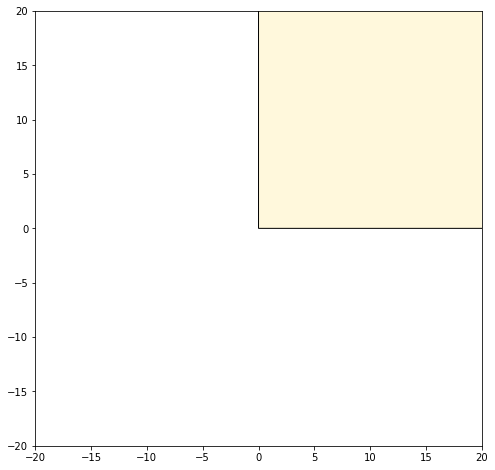

In [47]:
randomGrid= createRandomGrid(2777) #79 and 97 are interesting seeds// 97
#76953

asscociatesDirections = np.array([[0. , -1.],[1.,  0.], [0., 1.],[-1.,  0.] ])




In [21]:
np.save("numpyPieces/randomgrid", piece2)

In [22]:
intersection2DArray(np.array([[0,3]]), np.array([[1,0],[0,1]]))

array([], dtype=float64)

# N-Gon try


In [23]:
def findNormal(shape1, shape2):
    temp  = intersection2DArray(shape1, shape2)

    print(temp)
    temp = temp[0]-temp[1]
    print(temp)
    normal = np.array([-temp[1], temp[0]])
    return normal

In [30]:
def removeCenter(shape):
    temp = []
    for i in range(len(shape)):
        if(not np.allclose(shape[i], np.array([0,0]))):
            temp.append(shape[i])
    return np.asarray(temp)

In [29]:
def fusion(figure1, figure2):
    unionF2 = figure2[0]
    unionF2 = shy.Polygon(unionF2)
              
    for j in range(len(figure2)-1):
        unionF2 = unionF2.union(shy.Polygon(figure2[j+1]))
        
    for i in range(len(figure1)):
        try:
            figure1[i] = shy.Polygon(figure1[i]).difference(unionF2)
        except:
            print(i*len(figure2) + j)
            
    for i in range(len(figure1)):
        figure1[i] = np.array(figure1[i].exterior.coords)
        figure1[i] = removeCenter(figure1[i])
        
    temp = []
    for i in range(len(figure1)):
        temp.append(figure1[i])
    for i in range(len(figure2)):
        temp.append(figure2[i])
        
    simpleDisplay(np.array(temp))
    
    return np.array(temp)

In [51]:
def designNGon(n, r, width=0.4, height=0.4, space = 0.5):
    angle = 2*math.pi/n
    points = []
    points.append([r*math.sin(angle/2), -r*math.cos(angle/2)])
    points.append([-r*math.sin(angle/2), -r*math.cos(angle/2)])
    
    rotationMatrix = np.array([[math.cos(angle), math.sin(angle)], [-math.sin(angle), math.cos(angle)]])
    piece = []
    piece.append(np.array([points[0], points[1], [0,0]]))
    for i in range(n-1):
        points.append(rotationMatrix@ points[i+1])
        tempPiece = np.array([[0,0],points[i+1],points[i+2]])
        piece.append(tempPiece)
    for i in range(len(piece)):
        piece[i] = correctPoints(piece[i])
    for i in range(len(piece)):
        normal =findNormal(piece[i], piece[(i+1)%len(piece)])
        
        piece[i], piece[(i+1)%len(piece)] = designJoint2parts( piece[i], piece[(i+1)%len(piece)],normal, width, height, distance_to_center=space )
    simpleDisplay(piece)

    return piece

        

In [102]:
def NGonPrint(n, r):
    angle = 2*math.pi/n
    points = []
    points.append([r*math.sin(angle/2), -r*math.cos(angle/2)])
    points.append([-r*math.sin(angle/2), -r*math.cos(angle/2)])
    rotationMatrix = np.array([[math.cos(angle), math.sin(angle)], [-math.sin(angle), math.cos(angle)]])


    for i in range(n-1):
        

        points.append(rotationMatrix@ points[i+1])
    simpleDisplay(np.array([points]))
    return np.round(np.asarray(points))
    

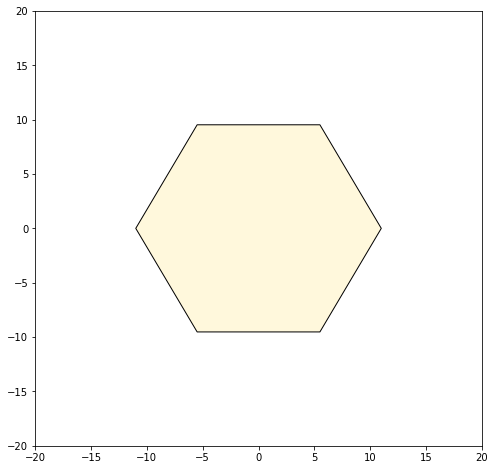

[[  5. -10.]
 [ -5. -10.]
 [-11.  -0.]
 [ -6.  10.]
 [  5.  10.]
 [ 11.   0.]
 [  6. -10.]]


In [103]:
hexa = NGonPrint(6,11)
print(hexa)

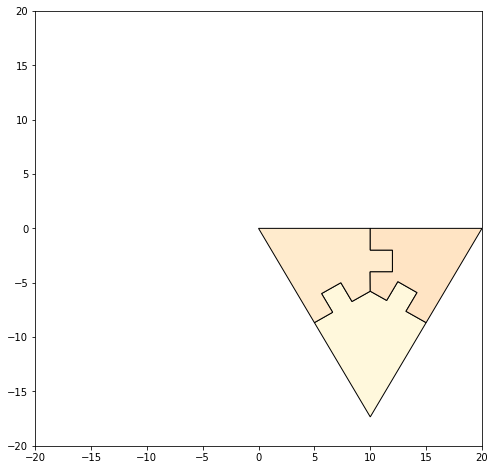

In [32]:
v1, f1 = igl.read_triangle_mesh("ressources/3-way-triangle/tri1.obj")
v2, f2 = igl.read_triangle_mesh("ressources/3-way-triangle/tri2.obj")
v3, f3 = igl.read_triangle_mesh("ressources/3-way-triangle/tri3.obj")
v1=np.flip(np.delete(v1, np.s_[1], 1), 0)
v2=np.flip(np.delete(v2, np.s_[1], 1), 0)
v3=np.flip(np.delete(v3, np.s_[1], 1), 0)
figureTriangle=np.array([v1,v2,v3])
simpleDisplay(figureTriangle)

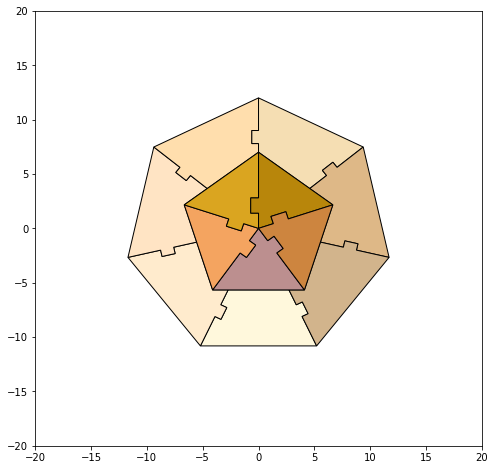

In [34]:
f =fusion(heptagon, pentagon)


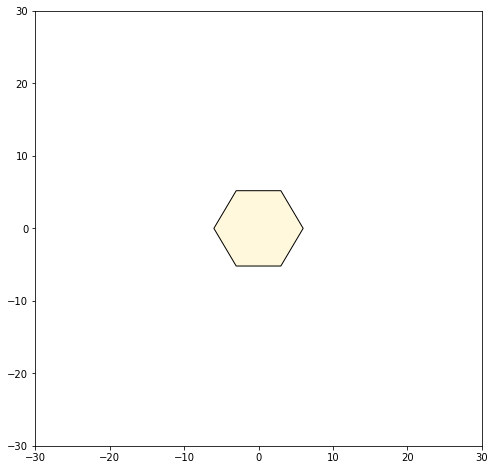

[[-3. -5.]
 [ 3. -5.]
 [ 6.  0.]
 [ 3.  5.]
 [-3.  5.]
 [-6. -0.]
 [-3. -5.]
 [ 3. -5.]]
[list([array([-3., -5.]), [-1.0, -5.0], [0.5, -1.0], [-1.8, -0.0], array([-4.5, -2.5])])
 list([[-1.0, -5.0], array([ 3., -5.]), array([ 4.5, -2.5]), array([ 2.  , -2.75]), [0.5, -1.0]])
 list([array([ 2.  , -2.75]), array([ 4.5, -2.5]), array([6., 0.]), array([3., 5.])])
 list([[0.5, -1.0], array([ 2.  , -2.75]), array([3., 5.]), array([-0.5,  5. ]), [0.0, 1.5], [-1.8, -0.0]])
 list([[-1.8, -0.0], [0.0, 1.5], array([-0.5,  5. ]), array([-3.,  5.]), array([-3.9,  3.5])])
 list([[-1.8, -0.0], array([-3.9,  3.5]), array([-6., -0.]), array([-4.5, -2.5])])]


In [331]:
h = NGonPrint(6,6)
h = h[::-1]
h = np.insert(h,0,h[-2],axis = 0) 
print(h)
cand1 = np.array([[h[0] , 
                  [2+h[0][0],h[0][1]],
                  [3.5+h[0][0],h[2][1]-1],
                  [h[0][0]+1.2, h[5][1]] ,
                  (h[5]+h[0])/2 ],
                  
                  
                 [[2+h[0][0],h[0][1]], 
                  h[1],
                  (h[1]+h[2])/2,
                  ((h[1]+h[2])/2+[(3.5+h[0][0]),h[2][1]-1])/2 -[0.5, 1],
                  [(3.5+h[0][0]),h[2][1]-1] ],
                  
                  [
                 ((h[1]+h[2])/2+[(3.5+h[0][0]),h[2][1]-1])/2 -[0.5, 1],
                 (h[1]+h[2])/2,
                 h[2],
                 h[3]
                  ],
                
                  
                  [[(3.5+h[0][0]),h[2][1]-1],
                   ((h[1]+h[2])/2+[(3.5+h[0][0]),h[2][1]-1])/2 -[0.5, 1],
                   h[3],
                   (h[3]+h[4])/2-[0.5, 0],
                   [h[0][0]+3, h[5][1]+1.5] ,
                   [h[0][0]+1.2, h[5][1]]
                  ],
                  [[h[0][0]+1.2, h[5][1]],
                   [h[0][0]+3, h[5][1]+1.5],
                   (h[3]+h[4])/2-[0.5, 0],
                   h[4],
                   (h[5]+h[4])/2 + 0.2*(h[4]-h[5])
                   
                  ],
                  
                 [
                    [h[0][0]+1.2, h[5][1]],
                   (h[5]+h[4])/2+ 0.2*(h[4]-h[5]),
                   h[5],
                   (h[5]+h[0])/2 
                  ]
                 
                 
                 
                 
                 ])
         
print(cand1)              
for i in range(len(cand1)):
    
    cand1[i] = correctPoints(cand1[i])            
cand1 = cand1*5              

In [332]:
cand1[1], cand1[0] = designJoint2parts(cand1[1], cand1[0], [-1,0],2,2 )
cand1[1], cand1[2] = designJoint2parts(cand1[1], cand1[2], [0,1],2,2 )
cand1[2], cand1[3] = designJoint2parts(cand1[2], cand1[3], [1,-1],2.5,3 )
cand1[4], cand1[3] = designJoint2parts(cand1[4], cand1[3], [-1,0],2,2)
cand1[4], cand1[5] = designJoint2parts(cand1[4], cand1[5], [-1,0],2,2 )
cand1[3], cand1[0] = designJoint2parts(cand1[3], cand1[0], [0,1],2,2 )
cand1[5], cand1[0] = designJoint2parts(cand1[5], cand1[0], [-1,1],2,2 )


np.save("hexagone.npy",cand1,  allow_pickle = True)

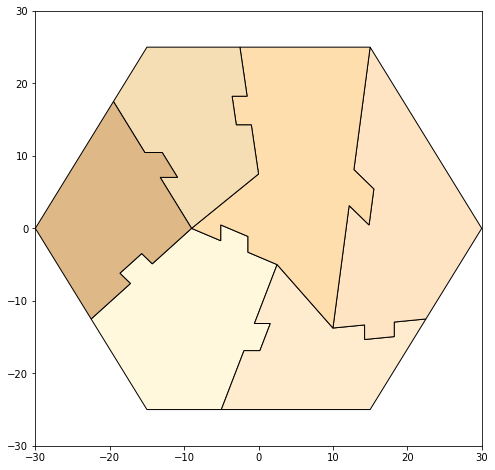

In [333]:
simpleDisplay(cand1)


In [334]:
printArray(cand1)

np.array([
np.array([
[ -14.282 , -4.891 ],
[ -15.698 , -3.476 ],
[ -18.633 , -6.194 ],
[ -17.218 , -7.609 ],
[ -22.5 , -12.5 ],
[ -15.0 , -25.0 ],
[ -5.0 , -25.0 ],
[ -1.952 , -16.873 ],
[ 0.184 , -16.873 ],
[ 1.588 , -13.127 ],
[ -0.548 , -13.127 ],
[ 2.5 , -5.0 ],
[ -1.416 , -3.297 ],
[ -1.416 , -1.117 ],
[ -5.084 , 0.478 ],
[ -5.084 , -1.703 ],
[ -9.0 , -0.0 ]
]),
np.array([
[ 18.24 , -12.926 ],
[ 18.24 , -14.936 ],
[ 14.26 , -15.334 ],
[ 14.26 , -13.324 ],
[ 10.0 , -13.75 ],
[ 2.5 , -5.0 ],
[ -0.548 , -13.127 ],
[ 1.588 , -13.127 ],
[ 0.184 , -16.873 ],
[ -1.952 , -16.873 ],
[ -5.0 , -25.0 ],
[ 15.0 , -25.0 ],
[ 22.5 , -12.5 ]
]),
np.array([
[ 12.82 , 8.104 ],
[ 15.499 , 5.425 ],
[ 14.859 , 0.466 ],
[ 12.18 , 3.146 ],
[ 10.0 , -13.75 ],
[ 14.26 , -13.324 ],
[ 14.26 , -15.334 ],
[ 18.24 , -14.936 ],
[ 18.24 , -12.926 ],
[ 22.5 , -12.5 ],
[ 30.0 , 0.0 ],
[ 15.0 , 25.0 ]
]),
np.array([
[ -5.084 , -1.703 ],
[ -5.084 , 0.478 ],
[ -1.416 , -1.117 ],
[ -1.416 , -3.297 ],
[ 2.5 , -5.0 ],
